In [1]:
import os
import sys
sys.path.append('/users/csmith36/shadows/git_ver')
import numpy as np
import matplotlib.pyplot as plt
from shadow_evolution_learning.pretrain import main
from shadow_evolution_learning.utils.operations import ket0, ket1, pX, pY, pZ
from shadow_evolution_learning.shadow_sampling.shadow_obs import estimate_shadow_observable
from shadow_evolution_learning.shadow_sampling import data_loader, load_and_partition
from shadow_evolution_learning.networks import denoising_prep
import jax
import jax.numpy as jnp

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Define Hamiltonian

In [2]:
vals = np.load('/users/csmith36/shadows/NNSHL/ising/ising_shadow_data/params.npy',allow_pickle=True)
val = vals[2]
pXX = jnp.kron(pX,pX)
hamil = val[0]*pXX + val[1]*jnp.kron(pZ,jnp.eye(2)) + val[2]*jnp.kron(jnp.eye(2),pZ)

Define Observables

In [3]:
obs_0 = [-jnp.kron(pZ,jnp.eye(2)),jnp.kron(pY,pX)]
obs_1 = [jnp.kron(jnp.eye(2),pX),jnp.kron(jnp.eye(2),pY)]
obs_2 = [jnp.kron(pX,jnp.eye(2)),jnp.kron(pY,jnp.eye(2))]
p_0 = jnp.kron(obs_0[0],obs_0[1])
p_1 = jnp.kron(obs_1[0],obs_1[1])
p_2 = jnp.kron(obs_2[0],obs_2[1])

q_0 = jnp.kron(obs_0[1],obs_0[1])
q_1 = jnp.kron(obs_1[1],obs_1[1])
q_2 = jnp.kron(obs_2[1],obs_2[1])

full_obs = [[p_0,q_0],[p_1,q_1],[p_2,q_2]]

p_0_s = np.array([2,1,0]), np.array([0,2,3])
p_1_s = np.array([0,1]), np.array([1,3])
p_2_s = np.array([0,1]), np.array([0,2])

q_0_s = np.array([1,0,1,0]), np.array([0,1,2,3])
q_1_s = np.array([1,1]), np.array([1,3])
q_2_s = np.array([1,1]), np.array([0,2])

full_shadow_obs = [[p_0_s,q_0_s],[p_1_s,q_1_s],[p_2_s,q_2_s]]

In [4]:
shadow_times = np.array([0.1 + 0.1*i for i in range(18)])
t=0.5
base_path='/users/csmith36/shadows/NNSHL/ising/ising_shadow_data/ket_00'
measurements = 10000
index = 2
key = jax.random.PRNGKey(42)
shadow = np.load(base_path+'/index='+str(index)+'/t='+str(round(t,3))+'/measurements='+str(measurements)+'/seed=0/shadow.npy',allow_pickle=True)
print(shadow.shape)
shadow_perm = jax.random.permutation(key,shadow,axis=1)
#print(shadow_perm.shape)
#print(shadow-shadow_perm)

(2, 10000, 4)


In [28]:
shadow_times = np.array([0.1 + 0.1*i for i in range(18)])
t=0.5
base_path='/users/csmith36/shadows/NNSHL/ising/ising_shadow_data/ket_00'
measurements = 10000
index = 2
#shadow = np.load(base_path+'/index='+str(index)+'/t='+str(round(t,3))+'/measurements='+str(measurements)+'/seed=0/shadow.npy',allow_pickle=True)
#print(shadow.shape)
key = jax.random.PRNGKey(42)
def partition_function(shadow,groups=10):
    shp = shadow.shape
    return shadow.reshape((shp[0],groups,-1,4)).transpose((1,0,2,3))
#shadow_part = partition_function(shadow)
#print(shadow_part.shape)

ps,qs = load_and_partition(key,10,shadow_times,10000,2,full_shadow_obs,k=1,perms=5)
ps_clean,qs_clean = load_and_partition(key,1,shadow_times,10000,2,full_shadow_obs,perms=1,k=1)

full_noisy = jnp.concatenate([ps,qs],axis=-1)
full_clean = jnp.concatenate([ps_clean,qs_clean],axis=-1)

#print(jnp.mean(jnp.abs(full_noisy-full_clean)))
#print(full_noisy.shape)
#A = jnp.array([i for i in range(10)])


(1, 6, 18)
(50, 6, 18)


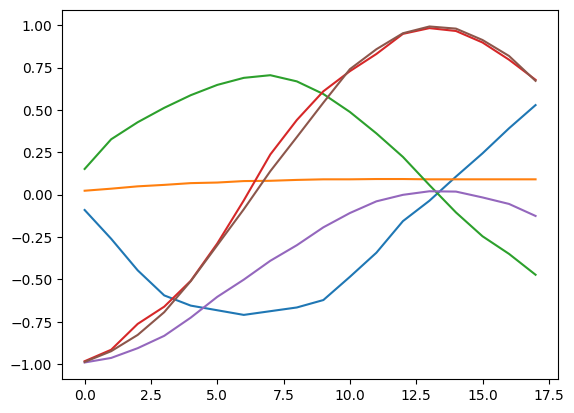

In [29]:
#full_noisy = jnp.concatenate([ps,qs],axis=-1)#.reshape((ps.shape[0],perms*groups,2*ps.shape[-1])).transpose(0,2,1)
#print(full_noisy.reshape((ps.shape[0],perms*groups,2*ps.shape[-1])))
#full_clean = jnp.concatenate([jnp.array(ps_clean),jnp.array(qs_clean)],axis=-1).transpose(0,2,1)
fnshp = full_noisy.shape
fcshp = full_clean.shape
full_noisy_reshape = full_noisy.reshape((fnshp[0],fnshp[1]*fnshp[2],-1)).transpose(1,2,0)
full_clean_reshape = full_clean.reshape((fcshp[0],1,-1)).transpose((1,2,0))
print(full_clean_reshape.shape)
print(full_noisy_reshape.shape)
plt.plot(full_clean[:,0,1])


Load Shadows

In [ ]:
def partition_function(shadow,groups=500):
    shp = shadow.shape
    return shadow.reshape((shp[0],groups,-1,4)).transpose((1,0,2,3))

def construct_noise(shadow):
    return np.abs(max(shadow,key=abs))/10*np.random.normal(loc=0.,scale=1.0,size=(20,shadow.shape[0])) + shadow


In [34]:
model = denoising_prep(layers=(250,100,50,25,10,25,50,100))
clean_loss, exact_loss, exact_clean = main(full_noisy_reshape,full_clean_reshape,model,shadow_times,hamil,full_obs,lr=0.01,seed=0,iters=2000,batch_size=10)

exact_obs.shape (1, 6, 18)
preds shape (10, 6, 18)
clean loss: 56.605343
exact loss: 56.26174
exact-clean loss: 2.0505023
exact_obs.shape (1, 6, 18)
preds shape (10, 6, 18)
clean loss: 46.620567
exact loss: 46.375595
exact-clean loss: 2.0505023
exact_obs.shape (1, 6, 18)
preds shape (10, 6, 18)
clean loss: 40.41169
exact loss: 40.347034
exact-clean loss: 2.0505023
exact_obs.shape (1, 6, 18)
preds shape (10, 6, 18)
clean loss: 37.731407
exact loss: 37.41477
exact-clean loss: 2.0505023
exact_obs.shape (1, 6, 18)
preds shape (10, 6, 18)
clean loss: 29.065271
exact loss: 28.66171
exact-clean loss: 2.0505023
exact_obs.shape (1, 6, 18)
preds shape (10, 6, 18)
clean loss: 26.239658
exact loss: 25.771042
exact-clean loss: 2.0505023
exact_obs.shape (1, 6, 18)
preds shape (10, 6, 18)
clean loss: 25.070335
exact loss: 24.809427
exact-clean loss: 2.0505023
exact_obs.shape (1, 6, 18)
preds shape (10, 6, 18)
clean loss: 23.963284
exact loss: 23.700815
exact-clean loss: 2.0505023
exact_obs.shape (1, 

KeyboardInterrupt: 